In [1]:
# Ank Soni 2019204
# Hritik Dhoke 2019069

In [2]:
import pandas as pd 
import numpy as np 

In [3]:
import sklearn 
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn import svm, datasets
from sklearn import preprocessing 

In [4]:
import nltk
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
import matplotlib.pyplot as plt 
from matplotlib import rcParams
import seaborn as sns
from textblob import TextBlob
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import iplot
%matplotlib inline

In [6]:
raw_reviews = pd.read_csv('Musical_instruments_reviews.csv')
print ("The shape of the  data is (row, column):"+ str(raw_reviews.shape))
print (raw_reviews.info())

The shape of the  data is (row, column):(10261, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10261 entries, 0 to 10260
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviewerID      10261 non-null  object 
 1   asin            10261 non-null  object 
 2   reviewerName    10234 non-null  object 
 3   helpful         10261 non-null  object 
 4   reviewText      10254 non-null  object 
 5   overall         10261 non-null  float64
 6   summary         10261 non-null  object 
 7   unixReviewTime  10261 non-null  int64  
 8   reviewTime      10261 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 721.6+ KB
None


In [7]:
raw_reviews.head()

reviewerID        asin  \
0  A2IBPI20UZIR0U  1384719342   
1  A14VAT5EAX3D9S  1384719342   
2  A195EZSQDW3E21  1384719342   
3  A2C00NNG1ZQQG2  1384719342   
4   A94QU4C90B1AX  1384719342   

                                       reviewerName   helpful  \
0  cassandra tu "Yeah, well, that's just like, u...    [0, 0]   
1                                              Jake  [13, 14]   
2                     Rick Bennette "Rick Bennette"    [1, 1]   
3                         RustyBill "Sunday Rocker"    [0, 0]   
4                                     SEAN MASLANKA    [0, 0]   

                                          reviewText  overall  \
0  Not much to write about here, but it does exac...      5.0   
1  The product does exactly as it should and is q...      5.0   
2  The primary job of this device is to block the...      5.0   
3  Nice windscreen protects my MXL mic and preven...      5.0   
4  This pop filter is great. It looks and perform...      5.0   

                                 summary  unixReviewTime   reviewTime  
0                                   good      1393545600  02 28, 2014  
1                                   Jake      1363392000  03 16, 2013  
2                   It Does The Job Well      1377648000  08 28, 2013  
3          GOOD WINDSCREEN FOR THE MONEY      1392336000  02 14, 2014  
4  No more pops when I record my vocals.      1392940800  02 21, 2014

## Data Pre-processing

In [8]:
#Creating a copy
process_reviews=raw_reviews.copy()

#Checking for null values
process_reviews.isnull().sum()

reviewerID         0
asin               0
reviewerName      27
helpful            0
reviewText         7
overall            0
summary            0
unixReviewTime     0
reviewTime         0
dtype: int64

In [9]:
# filling the missing values
process_reviews['reviewText']=process_reviews['reviewText'].fillna('Missing')

In [10]:
# concatenating review text and summary
process_reviews['reviews']=process_reviews['reviewText']+process_reviews['summary']
process_reviews=process_reviews.drop(['reviewText', 'summary'], axis=1)
process_reviews.head()

reviewerID        asin  \
0  A2IBPI20UZIR0U  1384719342   
1  A14VAT5EAX3D9S  1384719342   
2  A195EZSQDW3E21  1384719342   
3  A2C00NNG1ZQQG2  1384719342   
4   A94QU4C90B1AX  1384719342   

                                       reviewerName   helpful  overall  \
0  cassandra tu "Yeah, well, that's just like, u...    [0, 0]      5.0   
1                                              Jake  [13, 14]      5.0   
2                     Rick Bennette "Rick Bennette"    [1, 1]      5.0   
3                         RustyBill "Sunday Rocker"    [0, 0]      5.0   
4                                     SEAN MASLANKA    [0, 0]      5.0   

   unixReviewTime   reviewTime  \
0      1393545600  02 28, 2014   
1      1363392000  03 16, 2013   
2      1377648000  08 28, 2013   
3      1392336000  02 14, 2014   
4      1392940800  02 21, 2014   

                                             reviews  
0  Not much to write about here, but it does exac...  
1  The product does exactly as it should and is q...  
2  The primary job of this device is to block the...  
3  Nice windscreen protects my MXL mic and preven...  
4  This pop filter is great. It looks and perform...

In [11]:
# checking the overall review counts
process_reviews['overall'].value_counts()

5.0    6938
4.0    2084
3.0     772
2.0     250
1.0     217
Name: overall, dtype: int64

In [12]:
# defining a function for sentiments based on ratings
def rev(row):
    '''This function returns sentiment value based on the overall ratings from the user'''

    if row['overall'] == 3.0:
        val = 'Neutral'
    elif row['overall'] == 1.0 or row['overall'] == 2.0:
          val = 'Negative'
    elif row['overall'] == 4.0 or row['overall'] == 5.0:
          val = 'Positive'
    else:
          val = -1
    return val


In [13]:
# creating a sentiment coloumn to get better undestanding of the reviews
# if the rating is > 3 then review is considered positive 
# if the rating is < 3 then review is considered negative
# and if rating = 3 then review is considered neutral

process_reviews['sentiment'] = process_reviews.apply(rev,axis = 1)
process_reviews.head()

reviewerID        asin  \
0  A2IBPI20UZIR0U  1384719342   
1  A14VAT5EAX3D9S  1384719342   
2  A195EZSQDW3E21  1384719342   
3  A2C00NNG1ZQQG2  1384719342   
4   A94QU4C90B1AX  1384719342   

                                       reviewerName   helpful  overall  \
0  cassandra tu "Yeah, well, that's just like, u...    [0, 0]      5.0   
1                                              Jake  [13, 14]      5.0   
2                     Rick Bennette "Rick Bennette"    [1, 1]      5.0   
3                         RustyBill "Sunday Rocker"    [0, 0]      5.0   
4                                     SEAN MASLANKA    [0, 0]      5.0   

   unixReviewTime   reviewTime  \
0      1393545600  02 28, 2014   
1      1363392000  03 16, 2013   
2      1377648000  08 28, 2013   
3      1392336000  02 14, 2014   
4      1392940800  02 21, 2014   

                                             reviews sentiment  
0  Not much to write about here, but it does exac...  Positive  
1  The product does exactly as it should and is q...  Positive  
2  The primary job of this device is to block the...  Positive  
3  Nice windscreen protects my MXL mic and preven...  Positive  
4  This pop filter is great. It looks and perform...  Positive

In [14]:
process_reviews['sentiment'].value_counts()

Positive    9022
Neutral      772
Negative     467
Name: sentiment, dtype: int64

### Findind helpful rate
From the main dataframe we can see the helpful feature with values in list [a,b] format. It says that a out of b people found that review helpful. But with that format, it could not add value to the machine learning model and it will be difficult to decrypt the meaning for the machine. So we have planned to create helpful_rate feature which returns a/b value from [a,b]

In [15]:
# Splitting the dataset based on comma and square bracket 
new1 = process_reviews["helpful"].str.split(",", n = 1, expand = True)
new2 = new1[0].str.split("[", n = 1, expand = True)
new3 = new1[1].str.split("]", n = 1, expand = True)

#Resetting the index
new2.reset_index(drop=True, inplace=True)
new3.reset_index(drop=True, inplace=True)

#Dropping empty columns due to splitting 
new2=new2.drop([0], axis=1)
new3=new3.drop([1], axis=1)

#Concatenating the splitted columns
helpful=pd.concat([new2, new3], axis=1)


In [16]:
def trim_all_columns(df):
    """
    Trim whitespace from ends of each value across all series in dataframe
    """
    trim_strings = lambda x: x.strip() if isinstance(x, str) else x
    return df.applymap(trim_strings)

In [17]:
#Applying the function
helpful= trim_all_columns(helpful)

#Converting into integer types
helpful[0]=helpful[0].astype(str).astype(int)
helpful[1]=helpful[1].astype(str).astype(int)

#Dividing the two columns, we have 0 in the second columns when dvided gives error, so ignoring those errors
try:
  helpful['result'] = helpful[1]/helpful[0]
except ZeroDivisionError:
  helpful['result']=0

#Filling the NaN values(created due to dividing) with 0
helpful['result'] = helpful['result'].fillna(0)

#Rounding of the results to two decimal places
helpful['result']=helpful['result'].round(2) 

#Attaching the results to a new column of the main dataframe
process_reviews['helpful_rate']=helpful['result']

#dropping the helpful column from main dataframe
process_reviews=process_reviews.drop(['helpful'], axis=1)

In [18]:
process_reviews.head()

reviewerID        asin  \
0  A2IBPI20UZIR0U  1384719342   
1  A14VAT5EAX3D9S  1384719342   
2  A195EZSQDW3E21  1384719342   
3  A2C00NNG1ZQQG2  1384719342   
4   A94QU4C90B1AX  1384719342   

                                       reviewerName  overall  unixReviewTime  \
0  cassandra tu "Yeah, well, that's just like, u...      5.0      1393545600   
1                                              Jake      5.0      1363392000   
2                     Rick Bennette "Rick Bennette"      5.0      1377648000   
3                         RustyBill "Sunday Rocker"      5.0      1392336000   
4                                     SEAN MASLANKA      5.0      1392940800   

    reviewTime                                            reviews sentiment  \
0  02 28, 2014  Not much to write about here, but it does exac...  Positive   
1  03 16, 2013  The product does exactly as it should and is q...  Positive   
2  08 28, 2013  The primary job of this device is to block the...  Positive   
3  02 14, 2014  Nice windscreen protects my MXL mic and preven...  Positive   
4  02 21, 2014  This pop filter is great. It looks and perform...  Positive   

   helpful_rate  
0          0.00  
1          0.93  
2          1.00  
3          0.00  
4          0.00

In [19]:
process_reviews['helpful_rate'].value_counts()

0.00    7215
1.00    2040
0.50     266
0.67     136
0.75     111
        ... 
0.56       1
0.15       1
0.13       1
0.43       1
0.69       1
Name: helpful_rate, Length: 65, dtype: int64

In [20]:
# handling review time

# new data frame which has date and year
new = process_reviews["reviewTime"].str.split(",", n = 1, expand = True) 
  
# making separate date column from new data frame 
process_reviews["date"]= new[0] 
  
# making separate year column from new data frame 
process_reviews["year"]= new[1] 

process_reviews=process_reviews.drop(['reviewTime'], axis=1)
process_reviews.head()

reviewerID        asin  \
0  A2IBPI20UZIR0U  1384719342   
1  A14VAT5EAX3D9S  1384719342   
2  A195EZSQDW3E21  1384719342   
3  A2C00NNG1ZQQG2  1384719342   
4   A94QU4C90B1AX  1384719342   

                                       reviewerName  overall  unixReviewTime  \
0  cassandra tu "Yeah, well, that's just like, u...      5.0      1393545600   
1                                              Jake      5.0      1363392000   
2                     Rick Bennette "Rick Bennette"      5.0      1377648000   
3                         RustyBill "Sunday Rocker"      5.0      1392336000   
4                                     SEAN MASLANKA      5.0      1392940800   

                                             reviews sentiment  helpful_rate  \
0  Not much to write about here, but it does exac...  Positive          0.00   
1  The product does exactly as it should and is q...  Positive          0.93   
2  The primary job of this device is to block the...  Positive          1.00   
3  Nice windscreen protects my MXL mic and preven...  Positive          0.00   
4  This pop filter is great. It looks and perform...  Positive          0.00   

    date   year  
0  02 28   2014  
1  03 16   2013  
2  08 28   2013  
3  02 14   2014  
4  02 21   2014

In [21]:
# Splitting the date 
new1 = process_reviews["date"].str.split(" ", n = 1, expand = True) 
  
# adding month to the main dataset 
process_reviews["month"]= new1[0] 
  
# adding day to the main dataset 
process_reviews["day"]= new1[1] 

process_reviews=process_reviews.drop(['date'], axis=1)
process_reviews.head()

reviewerID        asin  \
0  A2IBPI20UZIR0U  1384719342   
1  A14VAT5EAX3D9S  1384719342   
2  A195EZSQDW3E21  1384719342   
3  A2C00NNG1ZQQG2  1384719342   
4   A94QU4C90B1AX  1384719342   

                                       reviewerName  overall  unixReviewTime  \
0  cassandra tu "Yeah, well, that's just like, u...      5.0      1393545600   
1                                              Jake      5.0      1363392000   
2                     Rick Bennette "Rick Bennette"      5.0      1377648000   
3                         RustyBill "Sunday Rocker"      5.0      1392336000   
4                                     SEAN MASLANKA      5.0      1392940800   

                                             reviews sentiment  helpful_rate  \
0  Not much to write about here, but it does exac...  Positive          0.00   
1  The product does exactly as it should and is q...  Positive          0.93   
2  The primary job of this device is to block the...  Positive          1.00   
3  Nice windscreen protects my MXL mic and preven...  Positive          0.00   
4  This pop filter is great. It looks and perform...  Positive          0.00   

    year month day  
0   2014    02  28  
1   2013    03  16  
2   2013    08  28  
3   2014    02  14  
4   2014    02  21

### Review text- Punctuation Cleaning

In [22]:
#Removing unnecessary columns
process_reviews=process_reviews.drop(['reviewerName','unixReviewTime'], axis=1)
#Creating a copy 
clean_reviews=process_reviews.copy()

In [23]:
clean_reviews.head()

reviewerID        asin  overall  \
0  A2IBPI20UZIR0U  1384719342      5.0   
1  A14VAT5EAX3D9S  1384719342      5.0   
2  A195EZSQDW3E21  1384719342      5.0   
3  A2C00NNG1ZQQG2  1384719342      5.0   
4   A94QU4C90B1AX  1384719342      5.0   

                                             reviews sentiment  helpful_rate  \
0  Not much to write about here, but it does exac...  Positive          0.00   
1  The product does exactly as it should and is q...  Positive          0.93   
2  The primary job of this device is to block the...  Positive          1.00   
3  Nice windscreen protects my MXL mic and preven...  Positive          0.00   
4  This pop filter is great. It looks and perform...  Positive          0.00   

    year month day  
0   2014    02  28  
1   2013    03  16  
2   2013    08  28  
3   2014    02  14  
4   2014    02  21

In [24]:
import re
import string

def review_cleaning(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [25]:
process_reviews['reviews']=process_reviews['reviews'].apply(lambda x:review_cleaning(x))
process_reviews.head()

reviewerID        asin  overall  \
0  A2IBPI20UZIR0U  1384719342      5.0   
1  A14VAT5EAX3D9S  1384719342      5.0   
2  A195EZSQDW3E21  1384719342      5.0   
3  A2C00NNG1ZQQG2  1384719342      5.0   
4   A94QU4C90B1AX  1384719342      5.0   

                                             reviews sentiment  helpful_rate  \
0  not much to write about here but it does exact...  Positive          0.00   
1  the product does exactly as it should and is q...  Positive          0.93   
2  the primary job of this device is to block the...  Positive          1.00   
3  nice windscreen protects my mxl mic and preven...  Positive          0.00   
4  this pop filter is great it looks and performs...  Positive          0.00   

    year month day  
0   2014    02  28  
1   2013    03  16  
2   2013    08  28  
3   2014    02  14  
4   2014    02  21

### Review text- Punctuation Cleaning

In [26]:
stop_words= ['yourselves', 'between', 'whom', 'itself', 'is', "she's", 'up', 'herself', 'here', 'your', 'each', 
             'we', 'he', 'my', "you've", 'having', 'in', 'both', 'for', 'themselves', 'are', 'them', 'other',
             'and', 'an', 'during', 'their', 'can', 'yourself', 'she', 'until', 'so', 'these', 'ours', 'above', 
             'what', 'while', 'have', 're', 'more', 'only', "needn't", 'when', 'just', 'that', 'were', "don't", 
             'very', 'should', 'any', 'y', 'isn', 'who',  'a', 'they', 'to', 'too', "should've", 'has', 'before',
             'into', 'yours', "it's", 'do', 'against', 'on',  'now', 'her', 've', 'd', 'by', 'am', 'from', 
             'about', 'further', "that'll", "you'd", 'you', 'as', 'how', 'been', 'the', 'or', 'doing', 'such',
             'his', 'himself', 'ourselves',  'was', 'through', 'out', 'below', 'own', 'myself', 'theirs', 
             'me', 'why', 'once',  'him', 'than', 'be', 'most', "you'll", 'same', 'some', 'with', 'few', 'it',
             'at', 'after', 'its', 'which', 'there','our', 'this', 'hers', 'being', 'did', 'of', 'had', 'under',
             'over','again', 'where', 'those', 'then', "you're", 'i', 'because', 'does', 'all']

In [27]:
process_reviews['reviews'] = process_reviews['reviews'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
process_reviews.head()

reviewerID        asin  overall  \
0  A2IBPI20UZIR0U  1384719342      5.0   
1  A14VAT5EAX3D9S  1384719342      5.0   
2  A195EZSQDW3E21  1384719342      5.0   
3  A2C00NNG1ZQQG2  1384719342      5.0   
4   A94QU4C90B1AX  1384719342      5.0   

                                             reviews sentiment  helpful_rate  \
0  not much write but exactly supposed filters po...  Positive          0.00   
1  product exactly quite affordablei not realized...  Positive          0.93   
2  primary job device block breath would otherwis...  Positive          1.00   
3  nice windscreen protects mxl mic prevents pops...  Positive          0.00   
4  pop filter great looks performs like studio fi...  Positive          0.00   

    year month day  
0   2014    02  28  
1   2013    03  16  
2   2013    08  28  
3   2014    02  14  
4   2014    02  21

## Some EDA for better understanding of data

In [28]:
# to look whether there is any relationship between sentiment of review and helpfulness of it
pd.DataFrame(process_reviews.groupby('sentiment')['helpful_rate'].mean())

helpful_rate
sentiment              
Negative       0.307559
Neutral        0.275687
Positive       0.260505

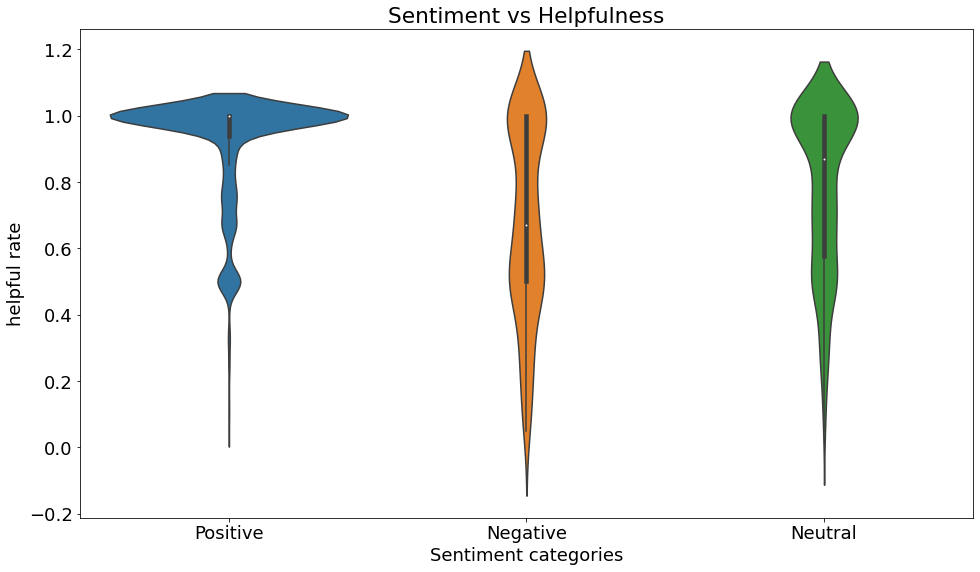

In [29]:
#plot layout
plt.rcParams.update({'font.size': 18})
rcParams['figure.figsize'] = 16,9

# Creating dataframe and removing 0 helpfulrate records
senti_help= pd.DataFrame(process_reviews, columns = ['sentiment', 'helpful_rate'])
senti_help = senti_help[senti_help['helpful_rate'] != 0.00] 

#Plotting phase
sns.violinplot( x=senti_help["sentiment"], y=senti_help["helpful_rate"])
plt.title('Sentiment vs Helpfulness')
plt.xlabel('Sentiment categories')
plt.ylabel('helpful rate')
plt.show()

From the plot we can declare that more number of positive reviews are having high helpful rate. We got deceived by the mean value, it's better to look at a plot rather than taking some measures of central tendency under such situation.

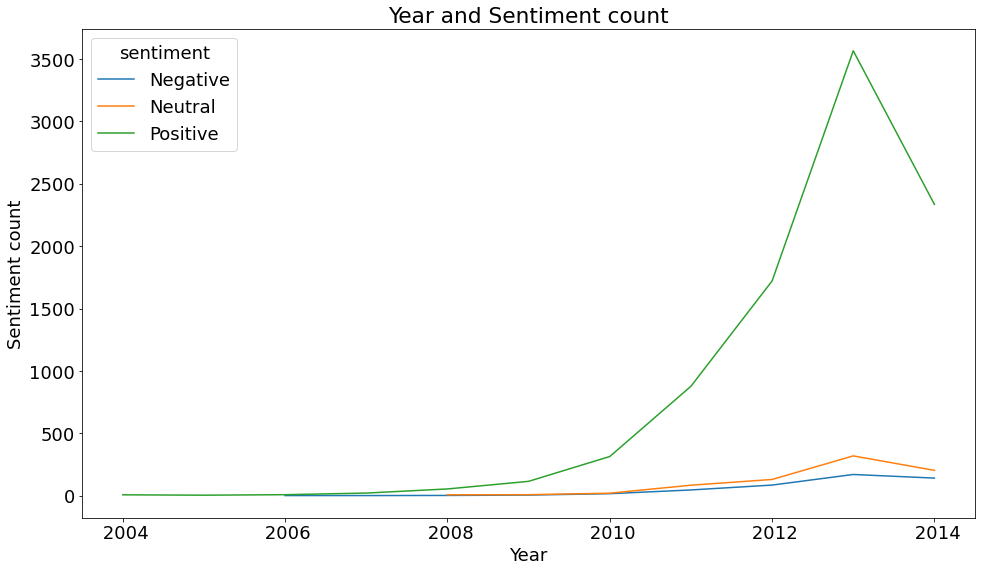

In [30]:
# year vs sentiment count
process_reviews.groupby(['year','sentiment'])['sentiment'].count().unstack().plot(legend=True)
plt.title('Year and Sentiment count')
plt.xlabel('Year')
plt.ylabel('Sentiment count')
plt.show()

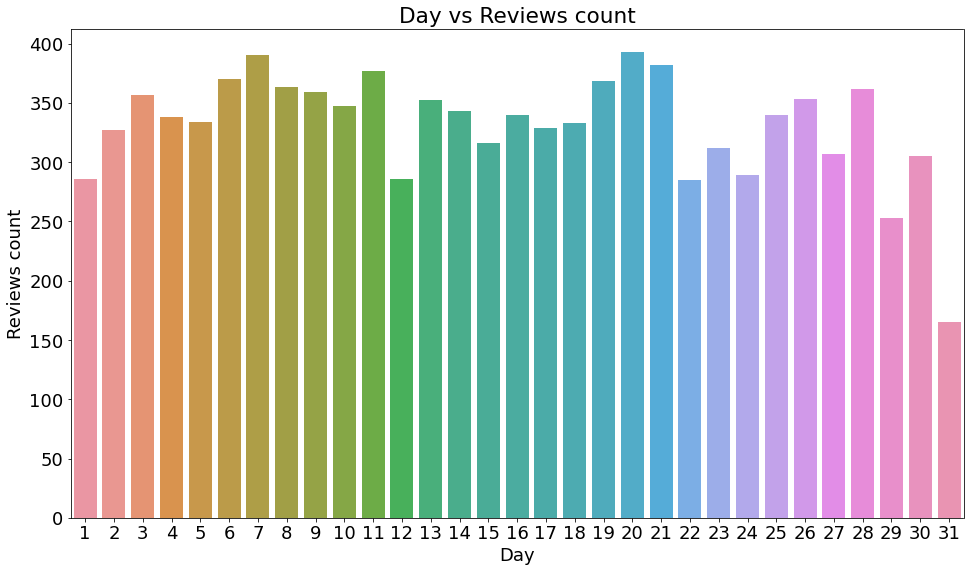

In [31]:
# Day of month vs review count
#Creating a dataframe
day=pd.DataFrame(process_reviews.groupby('day')['reviews'].count()).reset_index()
day['day']=day['day'].astype('int64')
day.sort_values(by=['day'])

#Plotting the graph
sns.barplot(x="day", y="reviews", data=day)
plt.title('Day vs Reviews count')
plt.xlabel('Day')
plt.ylabel('Reviews count')
plt.show()

### Creating few more features for text analysis

In [32]:
# Polarity: We use Textblob for for figuring out the rate of sentiment . It is between [-1,1] where -1 is negative and 1 is positive polarity
# Review length: length of the review which includes each letters and spaces
# Word length: This measures how many words are there in review

process_reviews['polarity'] = process_reviews['reviews'].map(lambda text: TextBlob(text).sentiment.polarity)
process_reviews['review_len'] = process_reviews['reviews'].astype(str).apply(len)
process_reviews['word_count'] = process_reviews['reviews'].apply(lambda x: len(str(x).split()))

In [33]:
process_reviews.head()

reviewerID        asin  overall  \
0  A2IBPI20UZIR0U  1384719342      5.0   
1  A14VAT5EAX3D9S  1384719342      5.0   
2  A195EZSQDW3E21  1384719342      5.0   
3  A2C00NNG1ZQQG2  1384719342      5.0   
4   A94QU4C90B1AX  1384719342      5.0   

                                             reviews sentiment  helpful_rate  \
0  not much write but exactly supposed filters po...  Positive          0.00   
1  product exactly quite affordablei not realized...  Positive          0.93   
2  primary job device block breath would otherwis...  Positive          1.00   
3  nice windscreen protects mxl mic prevents pops...  Positive          0.00   
4  pop filter great looks performs like studio fi...  Positive          0.00   

    year month day  polarity  review_len  word_count  
0   2014    02  28  0.250000         162          25  
1   2013    03  16  0.014286         356          55  
2   2013    08  28  0.167500         315          48  
3   2014    02  14  0.333333         169          22  
4   2014    02  21  0.800000         136          21

In [34]:
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [35]:
# plotting polarity distribution
process_reviews['polarity'].iplot(
    kind='hist',
    bins=50,
    xTitle='polarity',
    linecolor='black',
    yTitle='count',
    title='Sentiment Polarity Distribution')

We have a lot of positive polarities compared to the negative polarities
This polarity distributions assures the number of positive reviews we had
We can say that this polarity is a normally distributed but not standard normal

In [36]:
# plotting rating distribution
process_reviews['overall'].iplot(
    kind='hist',
    xTitle='rating',
    linecolor='black',
    yTitle='count',
    title='Review Rating Distribution')

We have a large number of 5 ratings(nearly 7k) followed by 4,3,2,1. It's linear in nature

In [37]:
# plotting Text Length Distribution
process_reviews['review_len'].iplot(
    kind='hist',
    bins=100,
    xTitle='review length',
    linecolor='black',
    yTitle='count',
    title='Review Text Length Distribution')


We have a right skewed distribution where most of the lengths falls between 0-1000

In [38]:
# plotting Text Word Count Distribution
process_reviews['word_count'].iplot(
    kind='hist',
    bins=100,
    xTitle='word count',
    linecolor='black',
    yTitle='count',
    title='Review Text Word Count Distribution')

We have a right skewed distribution with most of the words falling between 0-200 in a a review

In [39]:
review_pos = process_reviews[process_reviews["sentiment"]=='Positive'].dropna()
review_neu = process_reviews[process_reviews["sentiment"]=='Neutral'].dropna()
review_neg = process_reviews[process_reviews["sentiment"]=='Negative'].dropna()

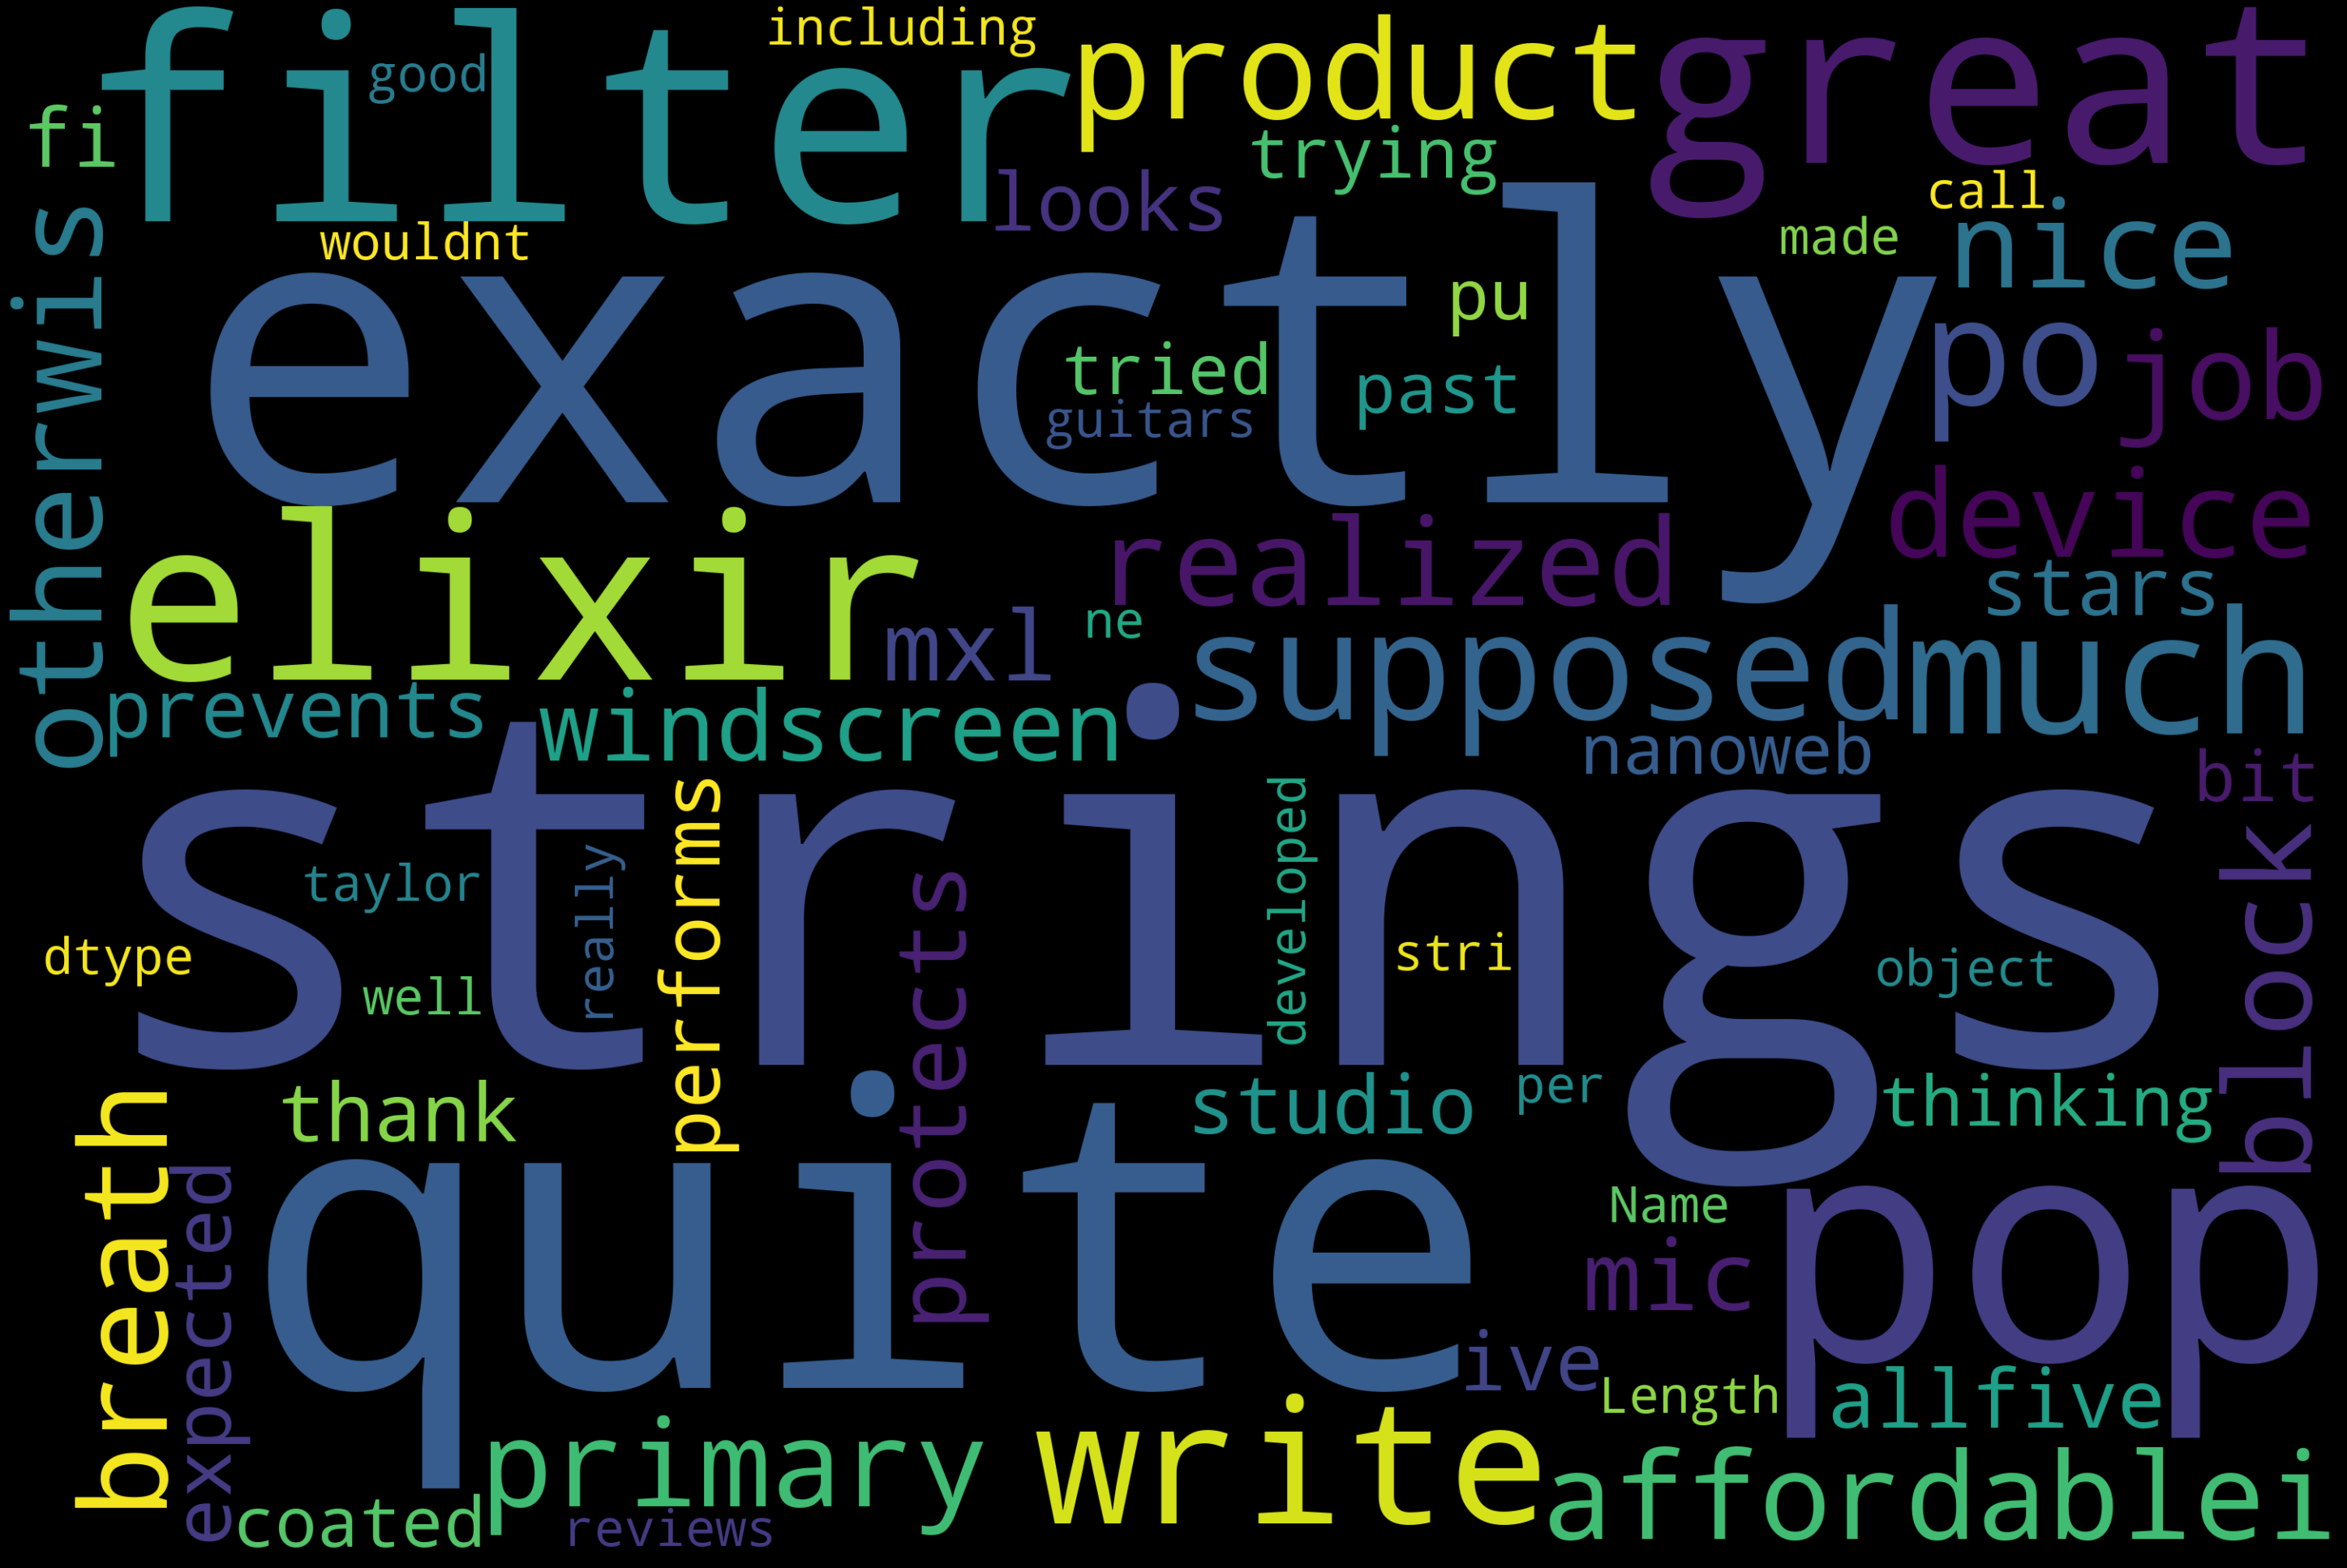

In [40]:
# word cloud of positive reviews
text = review_pos["reviews"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

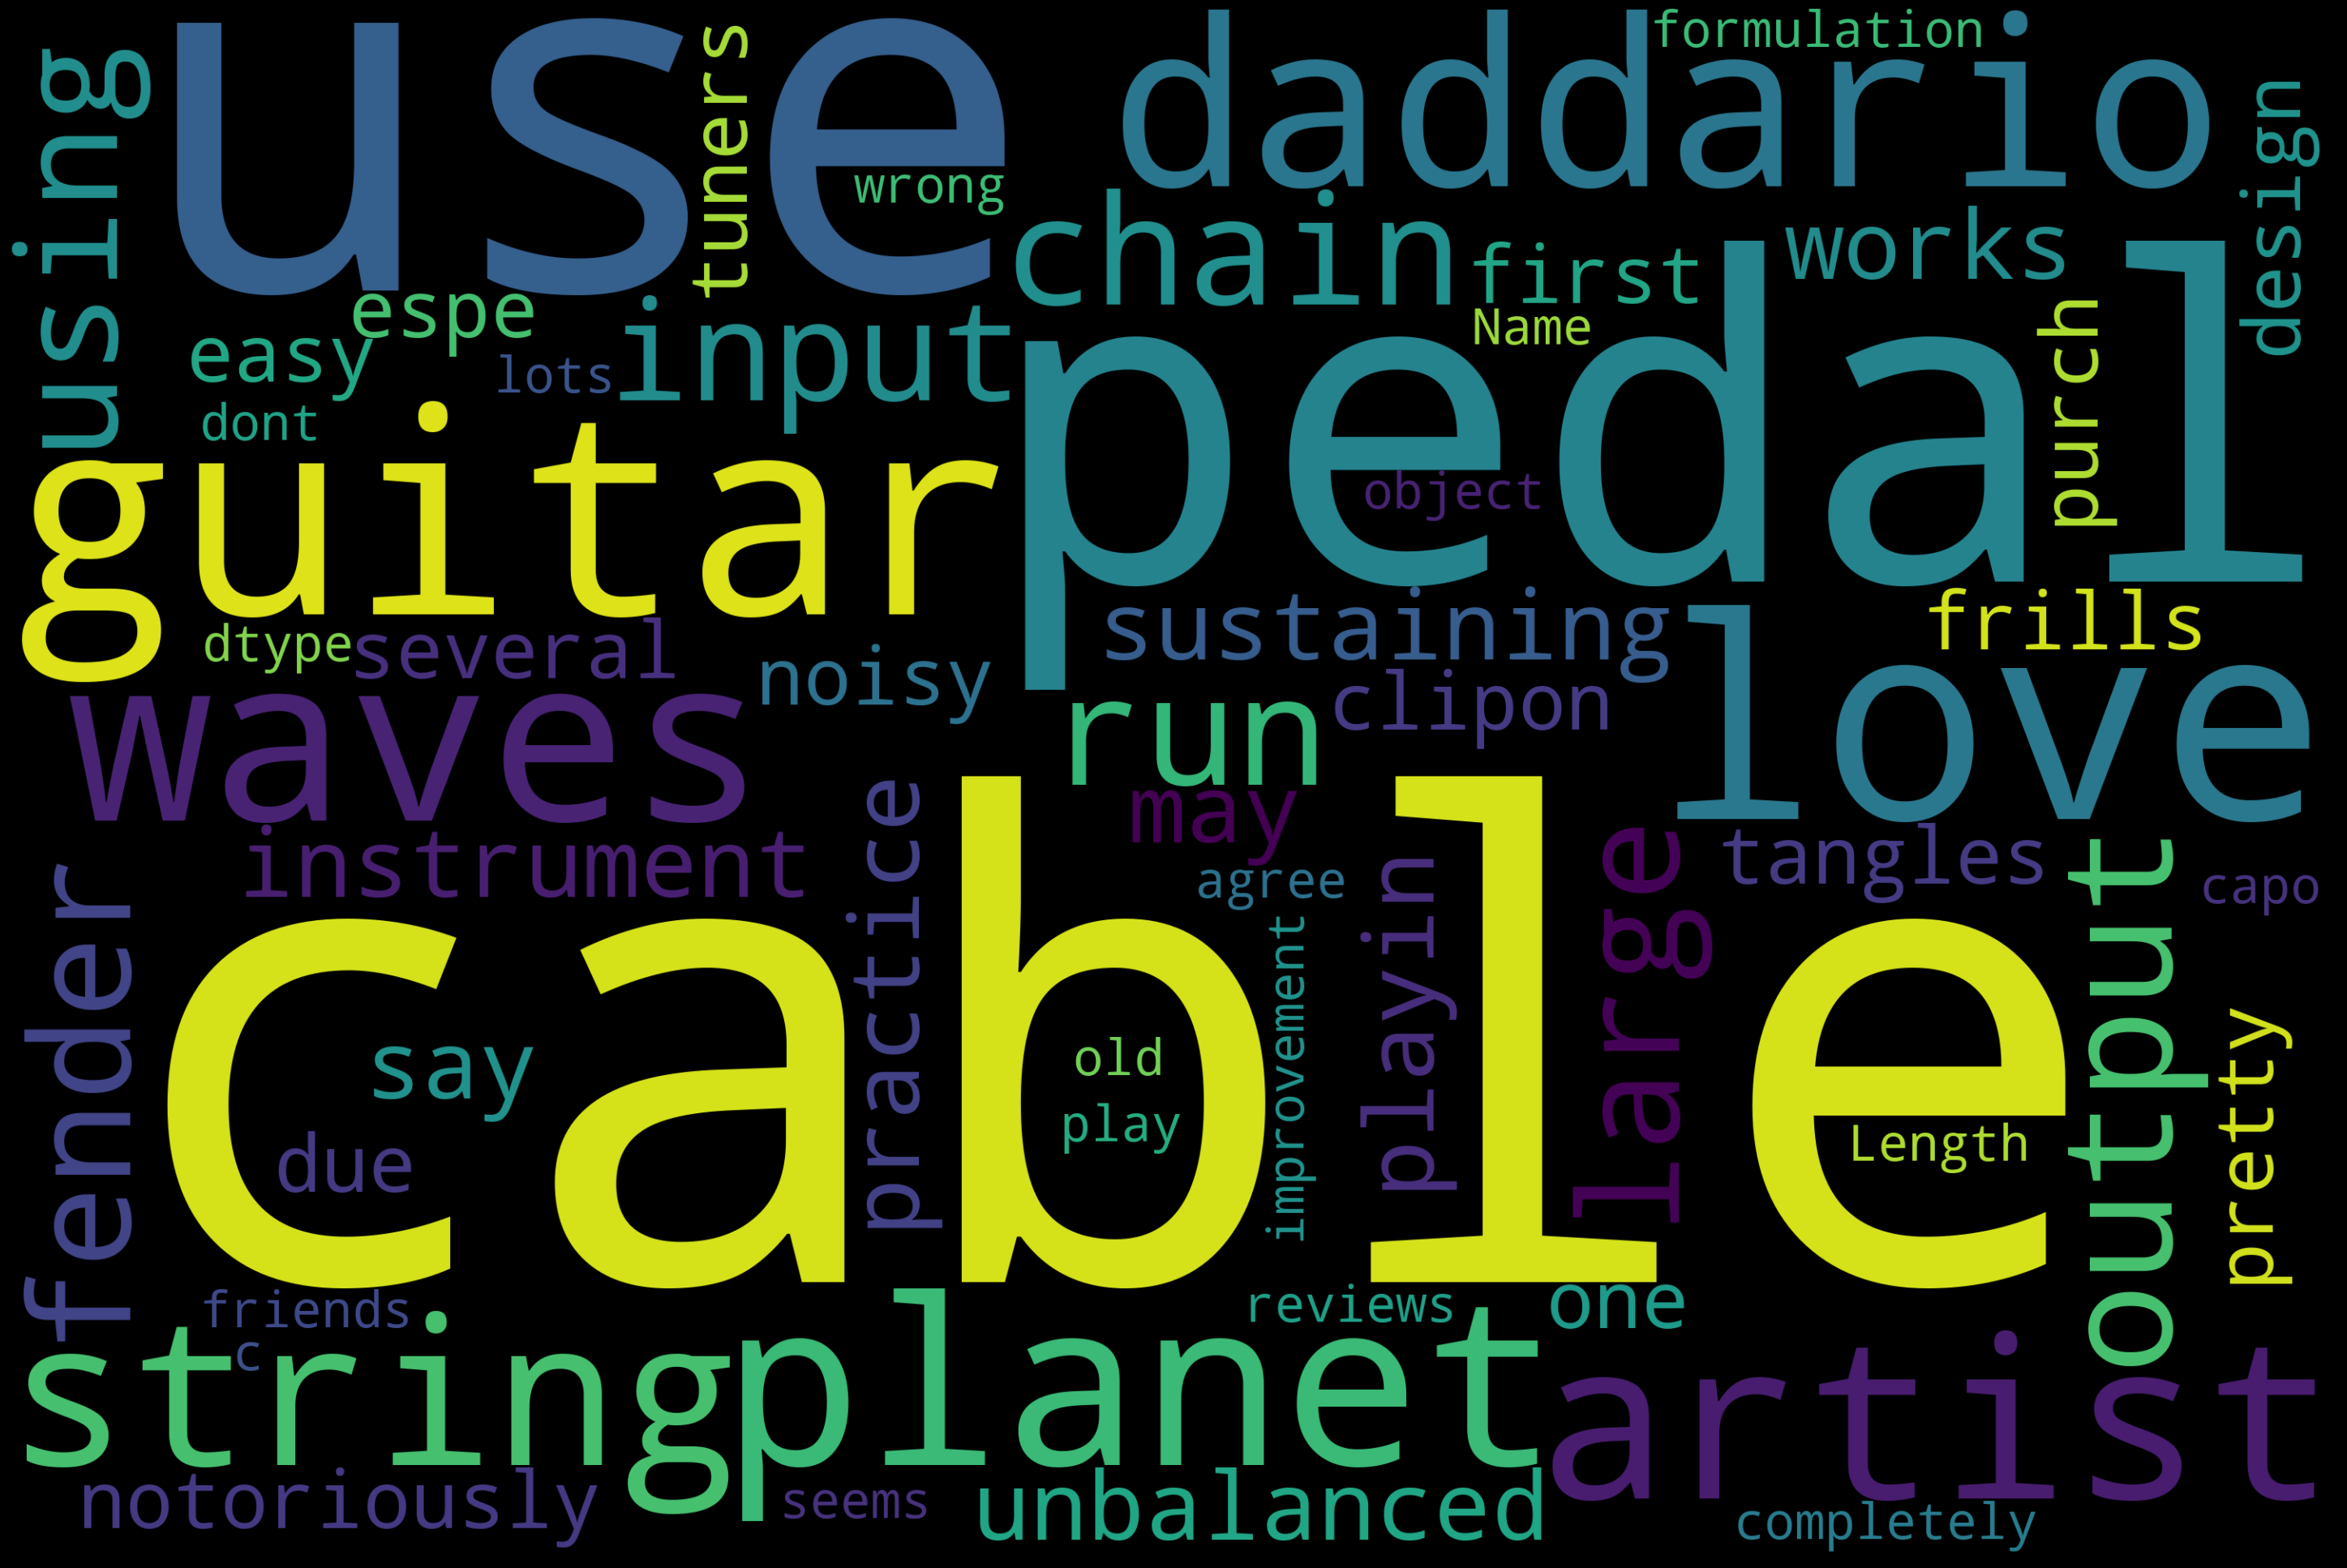

In [41]:
# word cloud of neutral reviews
text = review_neu["reviews"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

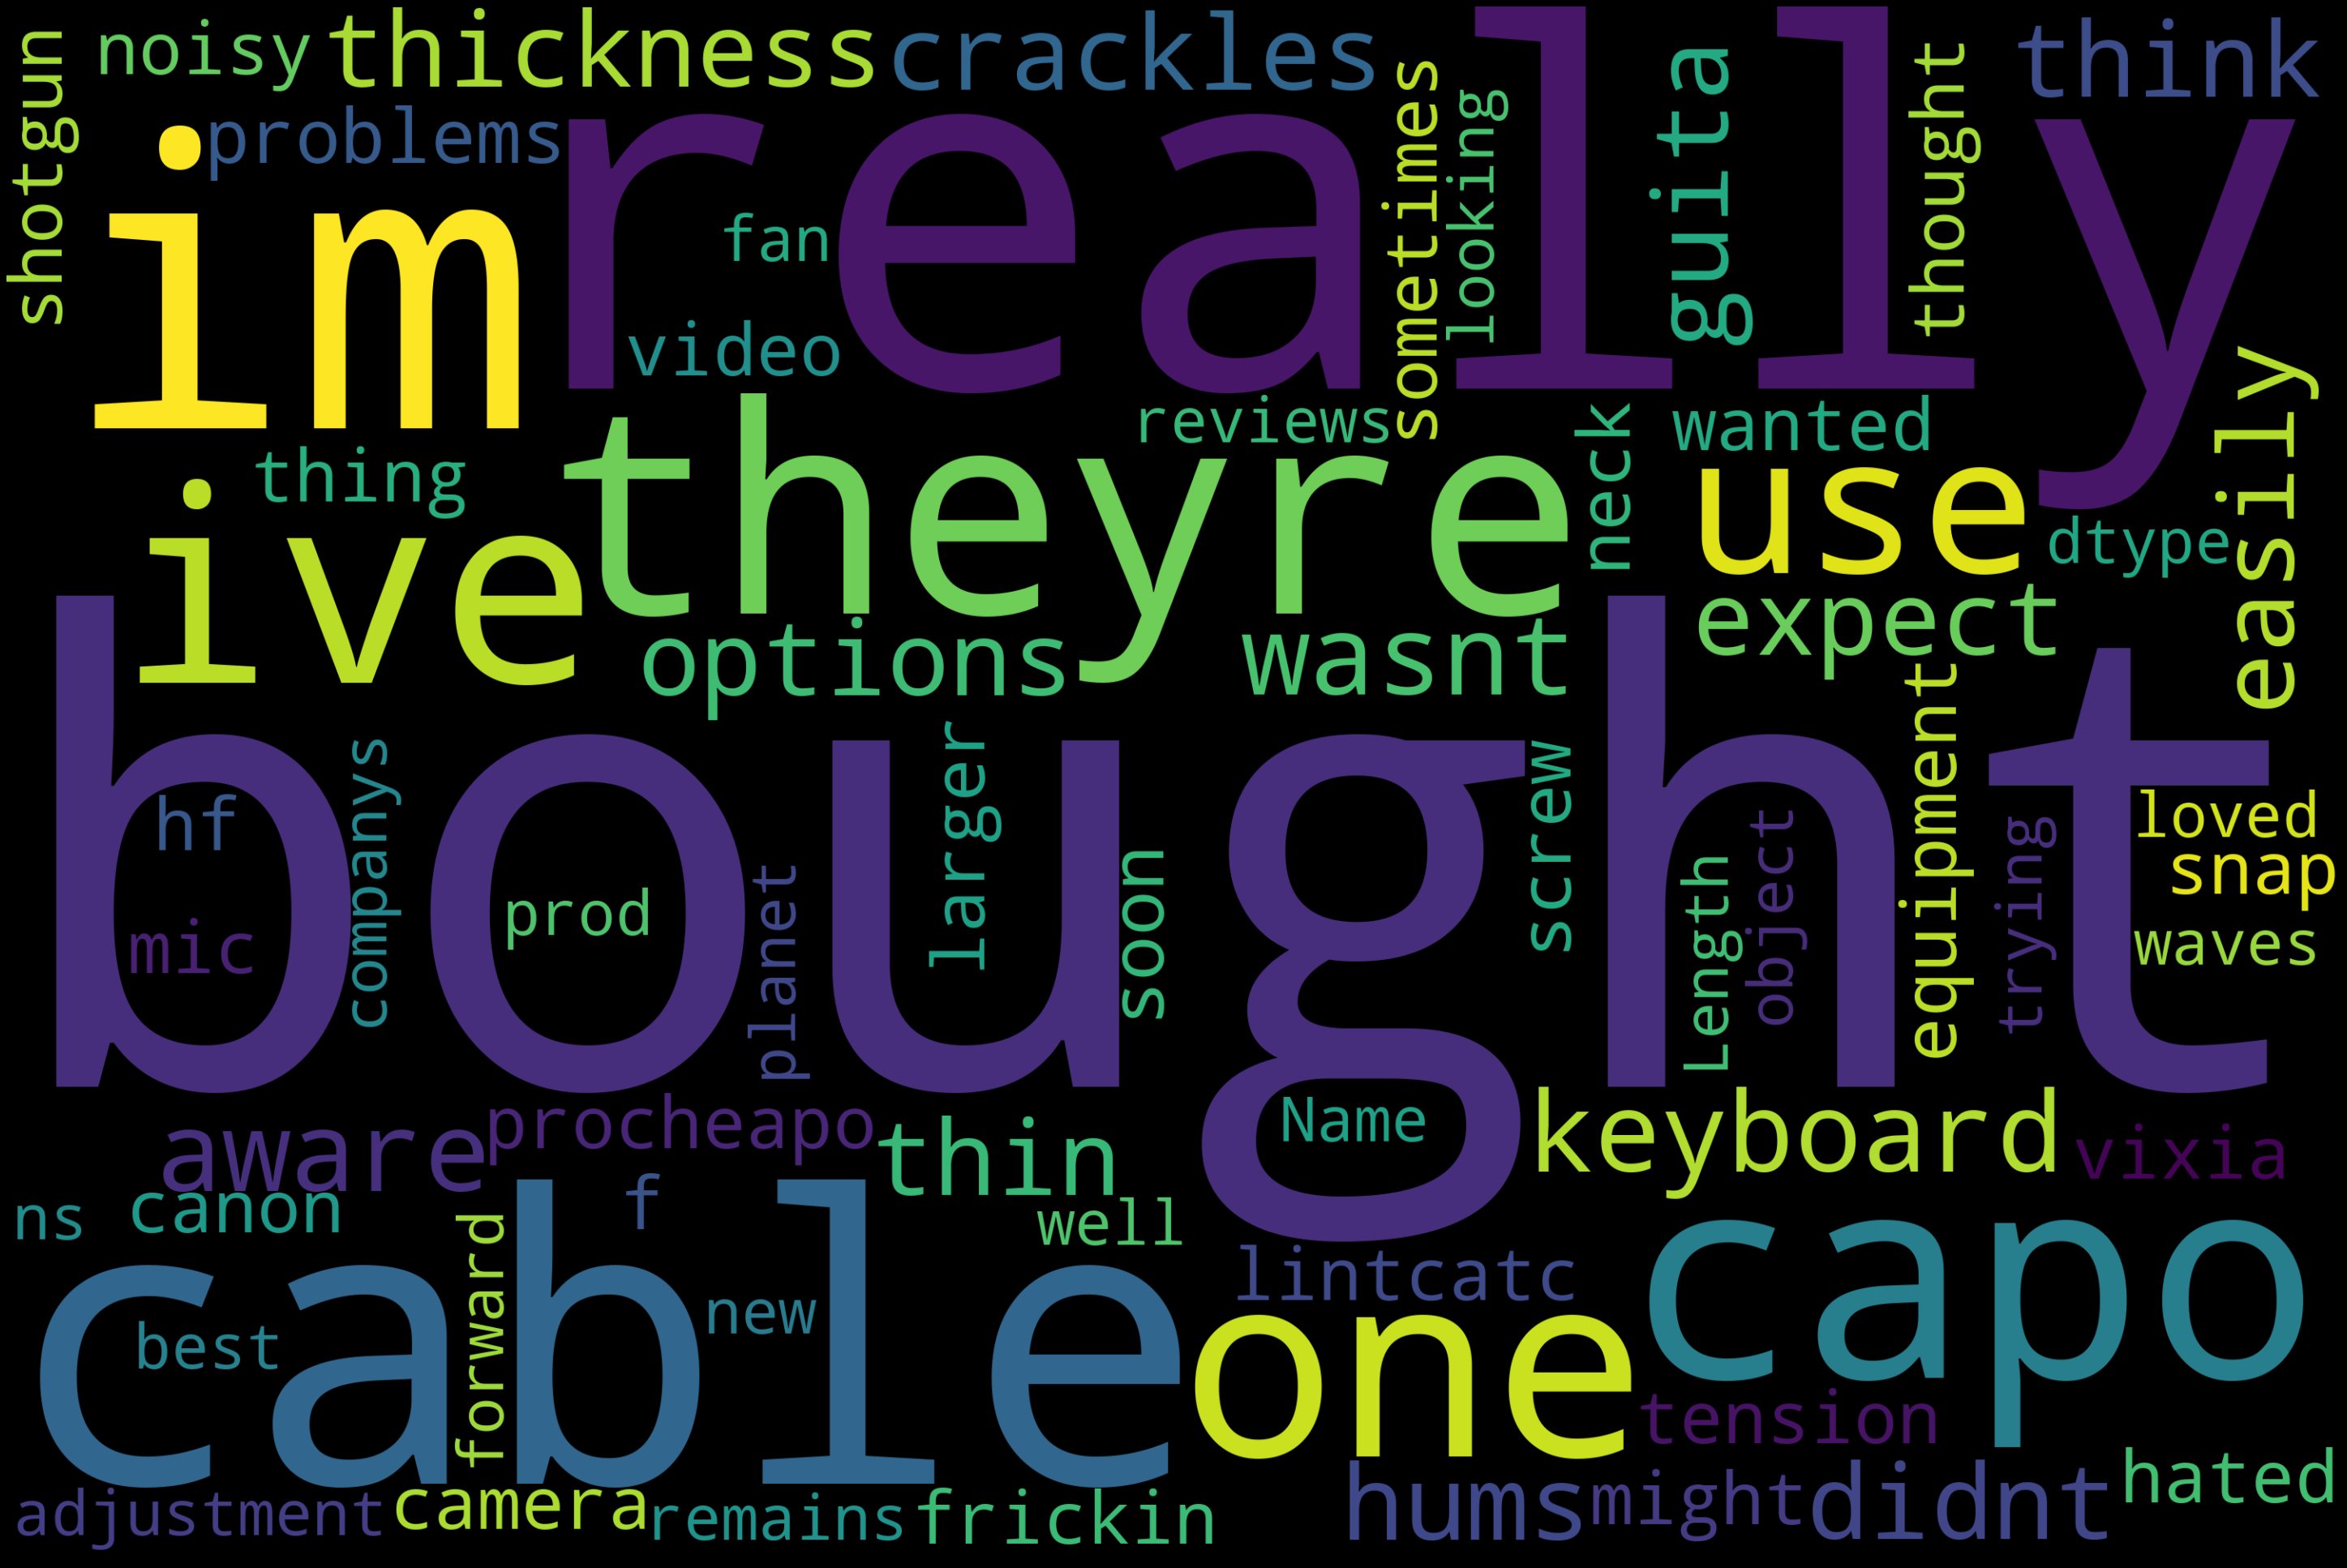

In [42]:
# word cloud of negative reviews
text = review_neg["reviews"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## Extracting Features from Cleaned reviews

### Label Encoding

In [43]:
# calling the label encoder function
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'sentiment'. 
process_reviews['sentiment']= label_encoder.fit_transform(process_reviews['sentiment']) 
  
process_reviews['sentiment'].unique()

array([2, 1, 0])

In [44]:
process_reviews['sentiment'].value_counts()

2    9022
1     772
0     467
Name: sentiment, dtype: int64

### Stemming the reviews
Stemming is a method of deriving root word from the inflected word. Here we extract the reviews and convert the words in reviews to its root word.

In [45]:
#Extracting 'reviews' for processing
review_features=process_reviews.copy()
review_features=review_features[['reviews']].reset_index(drop=True)
review_features.head()

reviews
0  not much write but exactly supposed filters po...
1  product exactly quite affordablei not realized...
2  primary job device block breath would otherwis...
3  nice windscreen protects mxl mic prevents pops...
4  pop filter great looks performs like studio fi...

In [46]:
#Performing stemming on the review dataframe
ps = PorterStemmer()

#splitting and adding the stemmed words except stopwords
corpus = []
for i in range(0, len(review_features)):
    review = re.sub('[^a-zA-Z]', ' ', review_features['reviews'][i])
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stop_words]
    review = ' '.join(review)
    corpus.append(review)

In [47]:
corpus[1:4]

['product exactli quit affordablei not realiz doubl screen arriv even better expecteda ad bonu one screen carri small hint smell old grape candi use buy reminisc sake cannot stop put pop filter next nose smell record dif need pop filter will work well expens one may even come pleas aroma like mine didbuy product jake',
 'primari job devic block breath would otherwis produc pop sound allow voic pass no notic reduct volum high frequenc doubl cloth filter block pop let voic no color metal clamp mount attach mike stand secur enough keep attach goos neck need littl coax stay put itit job well',
 'nice windscreen protect mxl mic prevent pop thing gooseneck margin abl hold screen posit requir care posit clamp avoid sagginggood windscreen money']

### TFIDF(Term Frequency — Inverse Document Frequency)
TF-IDF stands for “Term Frequency — Inverse Document Frequency”. This is a technique to quantify a word in documents, we generally compute a weight to each word which signifies the importance of the word in the document and corpus. This method is a widely used technique in Information Retrieval and Text Mining.

In [48]:
# selecting 5000 words and applying TFIDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000,ngram_range=(2,2))
# TF-IDF feature matrix
X= tfidf_vectorizer.fit_transform(review_features['reviews'])

In [49]:
X.shape

(10261, 5000)

In [50]:
#Getting the target variable(encoded)
y=process_reviews['sentiment']

## Handling Imbalance target feature-SMOTE
In our target feature, we noticed that we got a lot of positive sentiments compared to negative and neutral. So it is crucial to balanced the classes in such situatio. Here we use SMOTE(Synthetic Minority Oversampling Technique) to balance out the imbalanced dataset problem.It aims to balance class distribution by randomly increasing minority class examples by replicating them.


In [51]:
from collections import Counter
from imblearn.over_sampling import SMOTE

In [52]:
print(f'Original dataset shape : {Counter(y)}')

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

print(f'Resampled dataset shape {Counter(y_res)}')

Original dataset shape : Counter({2: 9022, 1: 772, 0: 467})
Resampled dataset shape Counter({2: 9022, 1: 9022, 0: 9022})


## Test-Train split 

In [69]:
# Divide the dataset into Train and Test
# 75:25 ratio
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.25, random_state=0)

## Model Building: Sentiment Analysis

In [54]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Model selection

In [55]:
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

In [56]:
logreg_cv = LogisticRegression(random_state=0)
dt_cv=DecisionTreeClassifier()
knn_cv=KNeighborsClassifier()
svc_cv=SVC()
nb_cv=BernoulliNB()
cv_dict = {0: 'Logistic Regression', 1: 'Decision Tree',2:'KNN',3:'SVC',4:'Naive Bayes'}
cv_models=[logreg_cv,dt_cv,knn_cv,svc_cv,nb_cv]


for i,model in enumerate(cv_models):
    print("{} Test Accuracy: {}".format(cv_dict[i],cross_val_score(model, X, y, cv=10, scoring ='accuracy').mean()))

Logistic Regression Test Accuracy: 0.8810059200798708
Decision Tree Test Accuracy: 0.8162950245894949
KNN Test Accuracy: 0.8689214787482609
SVC Test Accuracy: 0.8795439317757772
Naive Bayes Test Accuracy: 0.8038184420263036


### Logistic Regression with Hyperparameter tuning

In [57]:
import warnings
warnings.filterwarnings('ignore')

In [58]:
# We use regularization parameter and penality for parameter tuning
param_grid = {'C': np.logspace(-4, 4, 50),
             'penalty':['l1', 'l2']}
clf = GridSearchCV(LogisticRegression(random_state=0), param_grid,cv=5, verbose=0,n_jobs=-1)
best_model = clf.fit(X_train,y_train)
print(best_model.best_estimator_)
print("The mean accuracy of the model is:",best_model.score(X_test,y_test))

LogisticRegression(C=10000.0, random_state=0)
The mean accuracy of the model is: 0.9405940594059405


In [59]:
# plotting best model
logreg = LogisticRegression(C=10000.0, random_state=0)
logreg.fit(X_train, y_train)
y_pred_lr = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.94


### Here we plot the confusion matrix check our f1 score

Confusion matrix, without normalization


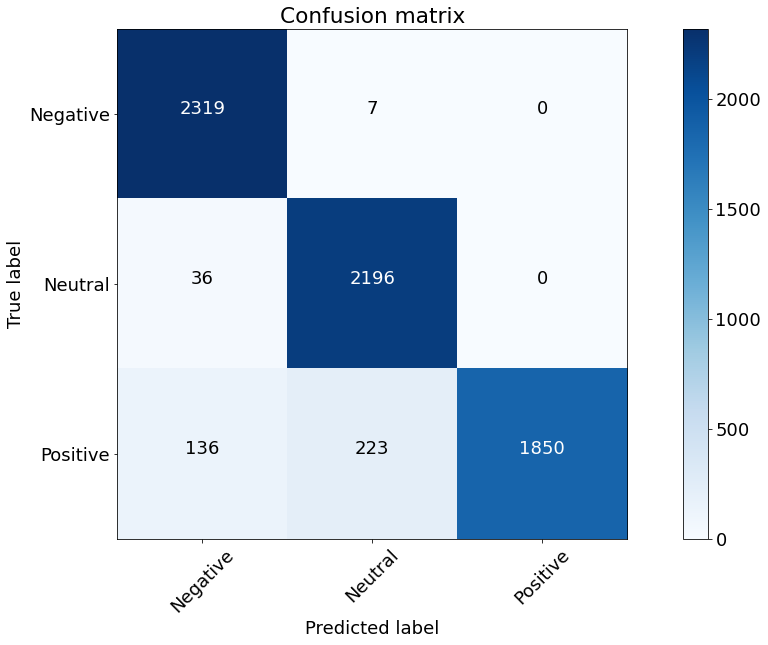

In [60]:
# classification metrics
cm = metrics.confusion_matrix(y_test, y_pred_lr)
plot_confusion_matrix(cm, classes=['Negative','Neutral','Positive'])

In [61]:
print("Classification Report:\n",classification_report(y_test, y_pred_lr))

Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96      2326
           1       0.91      0.98      0.94      2232
           2       1.00      0.84      0.91      2209

    accuracy                           0.94      6767
   macro avg       0.95      0.94      0.94      6767
weighted avg       0.94      0.94      0.94      6767



### SVC with Hyperparameter tuning

In [62]:
# We use regularization parameter and gamma for parameter tuning
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [2,1,0.1],'kernel': ['rbf']}
 
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=3)
best_mod = grid.fit(X_train,y_train)
print(best_mod.best_estimator_)
print("The mean accuracy of the model is:",best_mod.score(X_test,y_test))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END ........C=0.1, gamma=2, kernel=rbf;, score=0.755 total time=  27.3s
[CV 2/5] END ........C=0.1, gamma=2, kernel=rbf;, score=0.761 total time=  26.5s
[CV 3/5] END ........C=0.1, gamma=2, kernel=rbf;, score=0.748 total time=  26.3s
[CV 4/5] END ........C=0.1, gamma=2, kernel=rbf;, score=0.781 total time=  27.3s
[CV 5/5] END ........C=0.1, gamma=2, kernel=rbf;, score=0.763 total time=  27.7s
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.732 total time=  22.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.736 total time=  23.3s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.717 total time=  23.2s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.773 total time=  23.2s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.743 total time=  22.6s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.572 total time=  28.7s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;

In [70]:
# plotting best model
svc = SVC(C=1, gamma=2)
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)
print('Accuracy of support vector classifier on test set: {:.2f}'.format(svc.score(X_test, y_test)))

Accuracy of support vector classifier on test set: 0.97


### Here we plot the confusion matrix and check our f1 score

Confusion matrix, without normalization


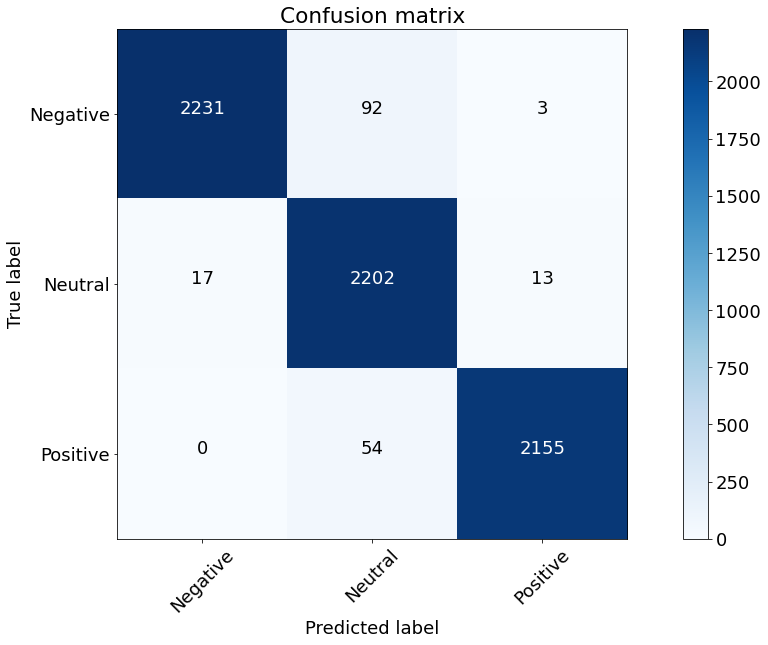

In [71]:
# # classification metrics
cm = metrics.confusion_matrix(y_test, y_pred_svc)
plot_confusion_matrix(cm, classes=['Negative','Neutral','Positive'])

In [72]:
print("Classification Report:\n",classification_report(y_test, y_pred_svc))

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.98      2326
           1       0.94      0.99      0.96      2232
           2       0.99      0.98      0.98      2209

    accuracy                           0.97      6767
   macro avg       0.97      0.97      0.97      6767
weighted avg       0.97      0.97      0.97      6767



We can see that the accuracy has increased significantly for both Logistic Regression and Support Vector Classifier 

## ROC-AUC curve

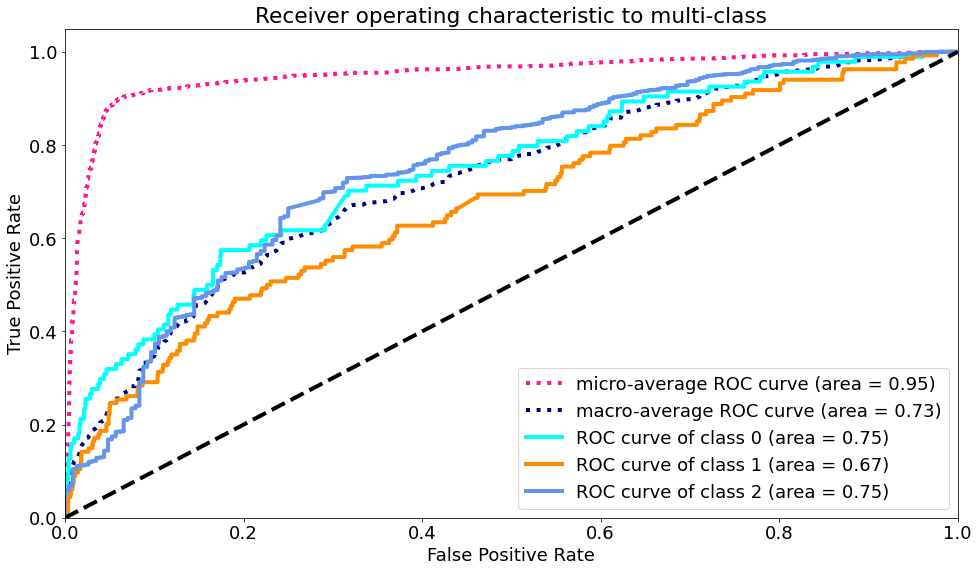

In [73]:
from scipy import interp
from itertools import cycle

#Binarizing the target feature
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

#Train-Test split(80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,
                                                    random_state=0)

#OneVsRestClassifier
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=10))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

#Computing TPR and FPR
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
# aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=4,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

## Using GWO for hyperparameter tuning

In [74]:
import random
import math
import time
    

def GWO(objf,lb,ub,dim,SearchAgents_no,Max_iter):


    #Max_iter=1000
    #lb=-100
    #ub=100
    #dim=30  
    #SearchAgents_no=5

    # initialize alpha, beta, and delta_pos
    Alpha_pos=np.zeros(dim)
    Alpha_score=float("inf")

    Beta_pos=np.zeros(dim)
    Beta_score=float("inf")

    Delta_pos=np.zeros(dim)
    Delta_score=float("inf")

    if not isinstance(lb, list):
        lb = [lb] * dim
    if not isinstance(ub, list):
        ub = [ub] * dim

    #Initialize the positions of search agents
    Positions = np.zeros((SearchAgents_no, dim))
    for i in range(dim):
        Positions[:, i] = np.random.uniform(0,1, SearchAgents_no) * (ub[i] - lb[i]) + lb[i]

    Convergence_curve=np.zeros(Max_iter)

     # Loop counter
    print("GWO is optimizing  \""+objf.__name__+"\"")    

    timerStart=time.time() 
    # Main loop
    for l in range(0,Max_iter):
        for i in range(0,SearchAgents_no):

            # Return back the search agents that go beyond the boundaries of the search space
            for j in range(dim):
                Positions[i,j]=np.clip(Positions[i,j], lb[j], ub[j])

            # Calculate objective function for each search agent
            fitness=objf(Positions[i,:])

            # Update Alpha, Beta, and Delta
            if fitness<Alpha_score :
                Alpha_score=fitness; # Update alpha
                Alpha_pos=Positions[i,:].copy()


            if (fitness>Alpha_score and fitness<Beta_score ):
                Beta_score=fitness  # Update beta
                Beta_pos=Positions[i,:].copy()


            if (fitness>Alpha_score and fitness>Beta_score and fitness<Delta_score): 
                Delta_score=fitness # Update delta
                Delta_pos=Positions[i,:].copy()




        a=2-l*((2)/Max_iter); # a decreases linearly from 2 to 0

        # Update the Position of search agents including omegas
        for i in range(0,SearchAgents_no):
            for j in range (0,dim):     

                r1=random.random() # r1 is a random number in [0,1]
                r2=random.random() # r2 is a random number in [0,1]

                A1=2*a*r1-a; # Equation (3.3)
                C1=2*r2; # Equation (3.4)

                D_alpha=abs(C1*Alpha_pos[j]-Positions[i,j]); # Equation (3.5)-part 1
                X1=Alpha_pos[j]-A1*D_alpha; # Equation (3.6)-part 1

                r1=random.random()
                r2=random.random()

                A2=2*a*r1-a; # Equation (3.3)
                C2=2*r2; # Equation (3.4)

                D_beta=abs(C2*Beta_pos[j]-Positions[i,j]); # Equation (3.5)-part 2
                X2=Beta_pos[j]-A2*D_beta; # Equation (3.6)-part 2       

                r1=random.random()
                r2=random.random() 

                A3=2*a*r1-a; # Equation (3.3)
                C3=2*r2; # Equation (3.4)

                D_delta=abs(C3*Delta_pos[j]-Positions[i,j]); # Equation (3.5)-part 3
                X3=Delta_pos[j]-A3*D_delta; # Equation (3.5)-part 3             

                Positions[i,j]=(X1+X2+X3)/3  # Equation (3.7)




        Convergence_curve[l]=Alpha_score

        if (l%1==0):
            print(['At iteration '+ str(l)+ ' the best fitness is '+ str(Alpha_score)])
            print('alpha:', np.where(Alpha_pos>0.5)[0])

    timerEnd=time.time()
    print('Completed in', (timerEnd - timerStart))


    return Alpha_pos

In [78]:
X_train_g, X_test_g, y_train_g, y_test_g = train_test_split(X_res, y_res, test_size=0.25, random_state=0)

In [79]:
def fitness_function(positions):
    print(positions)
    c = (abs(positions[0])) 
    g = (abs(positions[1])) 
    train_xf = X_train_g
    test_xf = X_test_g
    train_y = y_train_g
    test_y = y_test_g
    svc_classifier = svm.SVC(C = c, gamma = g)
    svc_classifier.fit(train_xf, train_y)
    
    accuracy = svc_classifier.score(test_xf, test_y)
    
    print('Accuracy:', accuracy, 1/accuracy)

    
    return 1/(accuracy)

In [80]:
fit = GWO(fitness_function, 1, 10, 2, 5, 5)

GWO is optimizing  "fitness_function"
[2.21761053 7.44673017]
Accuracy: 0.9708881335894783 1.0299847792998478
[2.42145673 6.3238024 ]
Accuracy: 0.9716270134476134 1.0292015209125476
[4.15622853 2.54200037]
Accuracy: 0.9754691887099157 1.025147704893198
[6.0334178  1.43097187]
Accuracy: 0.9750258607950347 1.0256138223704152
[7.62204815 6.19134002]
Accuracy: 0.9719225653908674 1.0288885510110992
['At iteration 0 the best fitness is 1.025147704893198']
alpha: [0 1]
[10.          1.88782046]
Accuracy: 0.9741392049652726 1.0265473300970873
[3.42631717 2.24532032]
Accuracy: 0.9770947243978129 1.0234422262552934
[7.84561393 1.16881066]
Accuracy: 0.9750258607950347 1.0256138223704152
[6.02611918 3.19216252]
Accuracy: 0.9731047731638836 1.0276385725132877
[8.53189534 6.55351698]
Accuracy: 0.9719225653908674 1.0288885510110992
['At iteration 1 the best fitness is 1.0234422262552934']
alpha: [0 1]
[7.90018805 1.63088088]
Accuracy: 0.9748780848234078 1.0257692890707897
[4.81603383 2.07220283]
Accu

In [83]:
# plotting best model C = 1.82015872 gamma = 1.71459372
svc = SVC(C=1.82015872, gamma=1.71459372)
svc.fit(X_train_g, y_train_g)
y_pred_svc_g = svc.predict(X_test_g)
print('Accuracy of support vector classifier on test set: {:.2f}'.format(svc.score(X_test_g, y_test_g)))

Accuracy of support vector classifier on test set: 0.98


Confusion matrix, without normalization


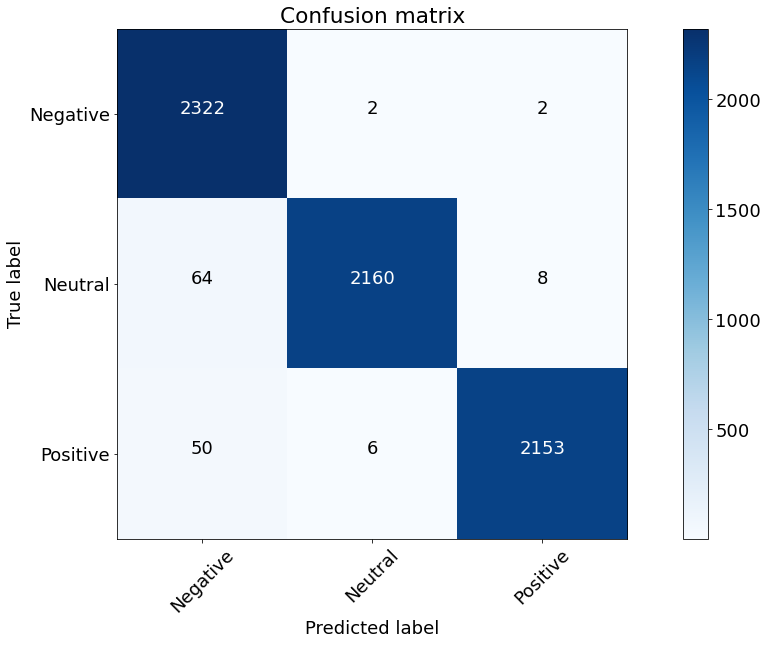

In [85]:
# # classification metrics
cm = metrics.confusion_matrix(y_test_g, y_pred_svc_g)
plot_confusion_matrix(cm, classes=['Negative','Neutral','Positive'])

In [87]:
print("Classification Report:\n",classification_report(y_test_g, y_pred_svc_g))

Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.98      2326
           1       1.00      0.97      0.98      2232
           2       1.00      0.97      0.98      2209

    accuracy                           0.98      6767
   macro avg       0.98      0.98      0.98      6767
weighted avg       0.98      0.98      0.98      6767



### Comparing the results

In [95]:
from tabulate import tabulate

l = [["Logistic Regression",0.88,0.94,'-'], ["SVC", 0.87, 0.97,0.98]]
table = tabulate(l, headers=['Classifier', 'Initaial Accuracy', 'After GridCV',' After GWO'], tablefmt='orgtbl')

print(table)

| Classifier          |   Initaial Accuracy |   After GridCV |  After GWO   |
|---------------------+---------------------+----------------+--------------|
| Logistic Regression |                0.88 |           0.94 | -            |
| SVC                 |                0.87 |           0.97 | 0.98         |
